# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [ ]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
df =pd.read_csv('/Users/ikkk/Desktop/T5 Camp/Week 6 Ali abdolmenem/5- Weekly Project/Night/Traffic Data.csv')

df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [3]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3278.186887,281.162680,0.048396,0.0,49.384600
std,1977.171357,12.661288,0.398007,0.0,39.647341
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1228.750000,271.950000,0.000000,0.0,1.000000
50%,3430.000000,281.825000,0.000000,0.0,75.000000
75%,4928.000000,291.840000,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


In [4]:
df.isna().sum()

traffic_volume         20
temp                    0
rain_1h                 0
snow_1h                 0
clouds_all              0
weather_main            0
weather_description     0
date_time               0
dtype: int64

In [5]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
19995    False
19996    False
19997    False
19998    False
19999    False
Length: 20000, dtype: bool

In [6]:
df.dtypes

traffic_volume         float64
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
dtype: object

In [7]:
df.shape

(20000, 8)

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

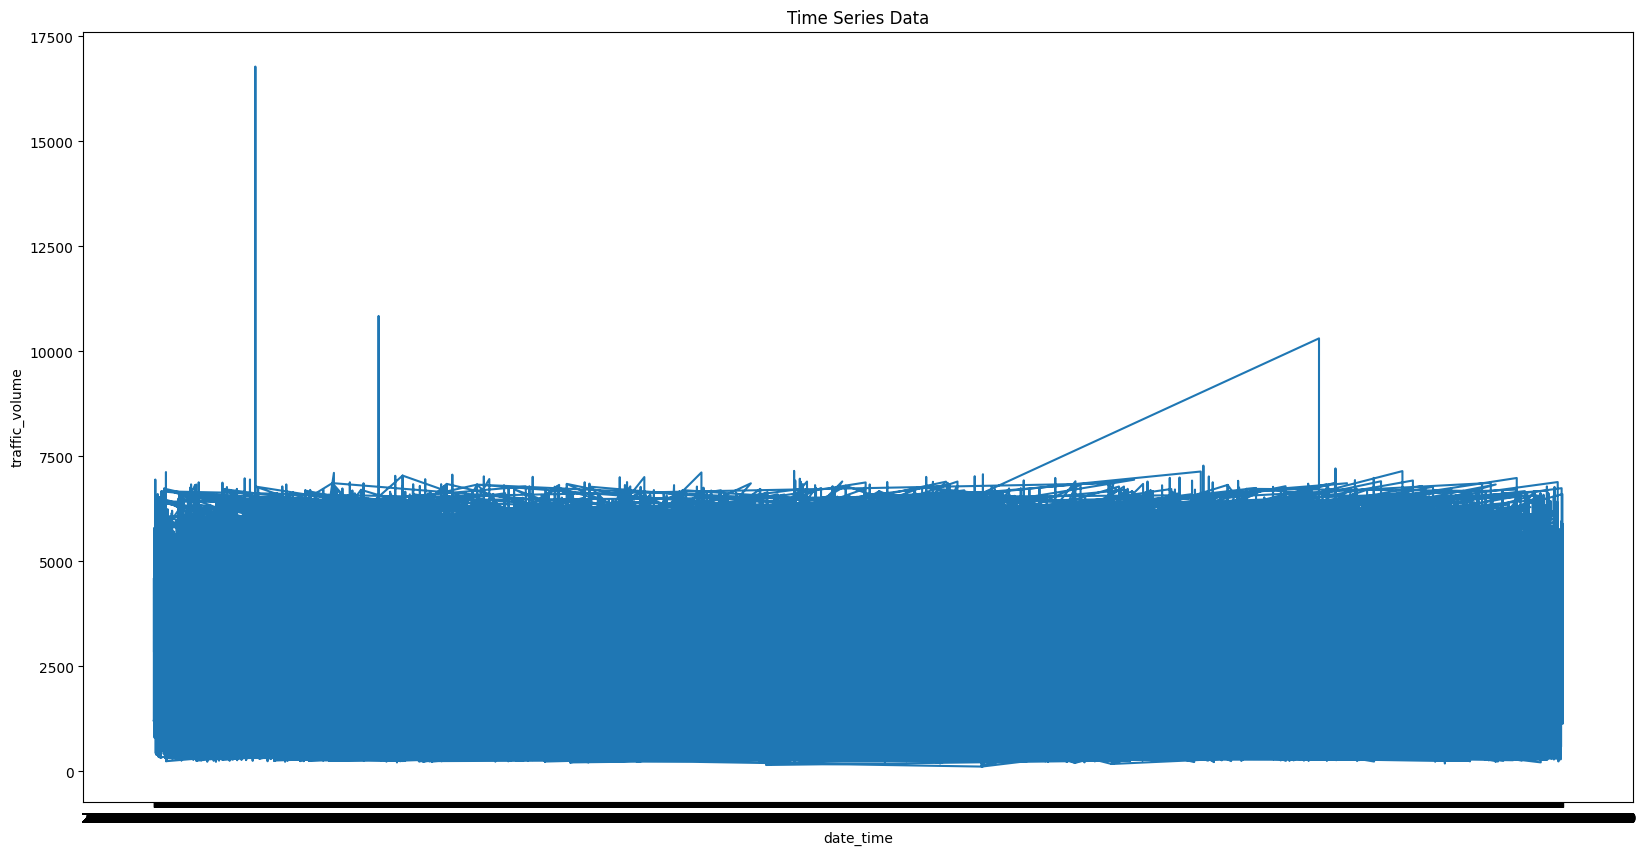

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(df['date_time'], df['traffic_volume'])
plt.title('Time Series Data')
plt.xlabel('date_time')
plt.ylabel('traffic_volume')
plt.show()

In [49]:
numeric_columns = ['traffic_volume', 'temp', 'rain_1h', 
                   'snow_1h', 'clouds_all', 'weather_main', 
                   'weather_description','date_time']

In [51]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
outliers_iqr = {}

for traffic_volume in numeric_columns:
    Q1 = df[traffic_volume].quantile(0.25)
    Q3 = df[traffic_volume].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[traffic_volume] < lower_bound) | (df[traffic_volume] > upper_bound)][traffic_volume]
    outliers_iqr[traffic_volume] = outliers
    

In [29]:
df = df[(df[traffic_volume] >= lower_bound) & (df[traffic_volume] <= upper_bound)]


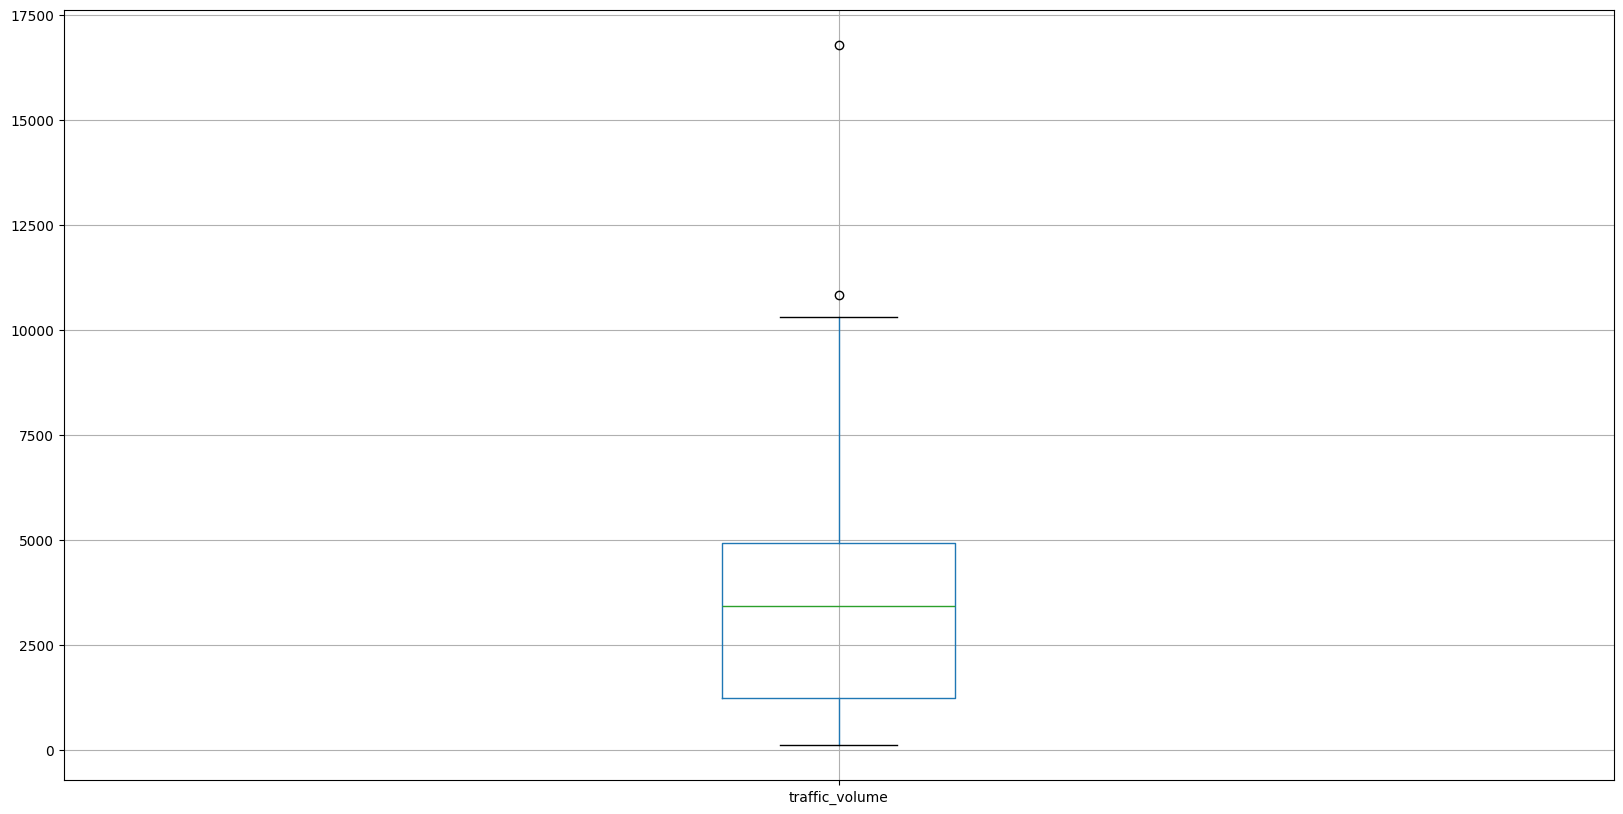

In [11]:

plt.figure(figsize=(20,10))
df.boxplot(column=['traffic_volume'])
plt.show()

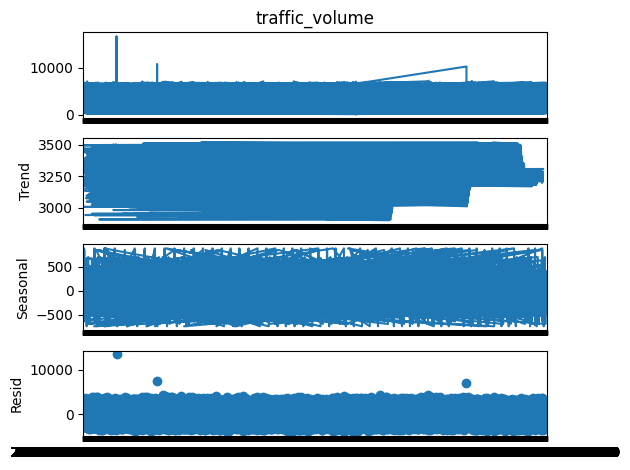

In [12]:
decomposition = seasonal_decompose(df.set_index('date_time')['traffic_volume'].dropna(), model='additive', period=365)
decomposition.plot()
plt.show()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [13]:
df.isna().sum()

traffic_volume         20
temp                    0
rain_1h                 0
snow_1h                 0
clouds_all              0
weather_main            0
weather_description     0
date_time               0
dtype: int64

In [16]:
df.fillna(method='ffill', inplace=True)
df.set_index('date_time', inplace=True)
aquifer_data = df.sort_index()
df.isna().sum()

/var/folders/yj/c5h4fglj5kdgcnv5jpkvcq400000gn/T/ipykernel_14691/3739508013.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


traffic_volume         0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
Prev_traffic_volume    1
dtype: int64

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [70]:
from sklearn.impute import SimpleImputer

selected_features = ['traffic_volume', 'temp', 'rain_1h','snow_1h', 'clouds_all', 'weather_main','weather_description']

data_encoded = pd.get_dummies(df[selected_features])
imputer = SimpleImputer(strategy='most_frequent')

In [87]:
df['Prev_traffic_volume'] = df['traffic_volume'].shift(1)
df['day_of_week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Day_of_year'] = df.index.dayofyear
df['IsWeekend'] = df['DayOfWeek'] >= 5
df['Diff_traffic_volume'] = df['traffic_volume'].diff()
df.dropna(inplace=True)



## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [18]:
X = df.drop(columns=['traffic_volume'])
y = df['traffic_volume']
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [52]:
target_column = 'traffic_volume'


In [54]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[[target_column]].values.reshape(-1, 1))

In [61]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [ ]:
#LSTM & GRU 

In [88]:
time_step = 100
X_train, y_train = create_dataset(scaled_data, time_step)
X_test, y_test = create_dataset(scaled_data, time_step)


### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [89]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=64, verbose=1)


Epoch 1/2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


311/311 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - loss: 0.0155 - val_loss: 0.0142
Epoch 2/2
311/311 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - loss: 0.0142 - val_loss: 0.0143


### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [90]:

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


622/622 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
622/622 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [91]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])




In [97]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train %.2f RMSE' % (train_score))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test %.2f RMSE' % (test_score))


Train 1994.26 RMSE
Test 1994.26 RMSE


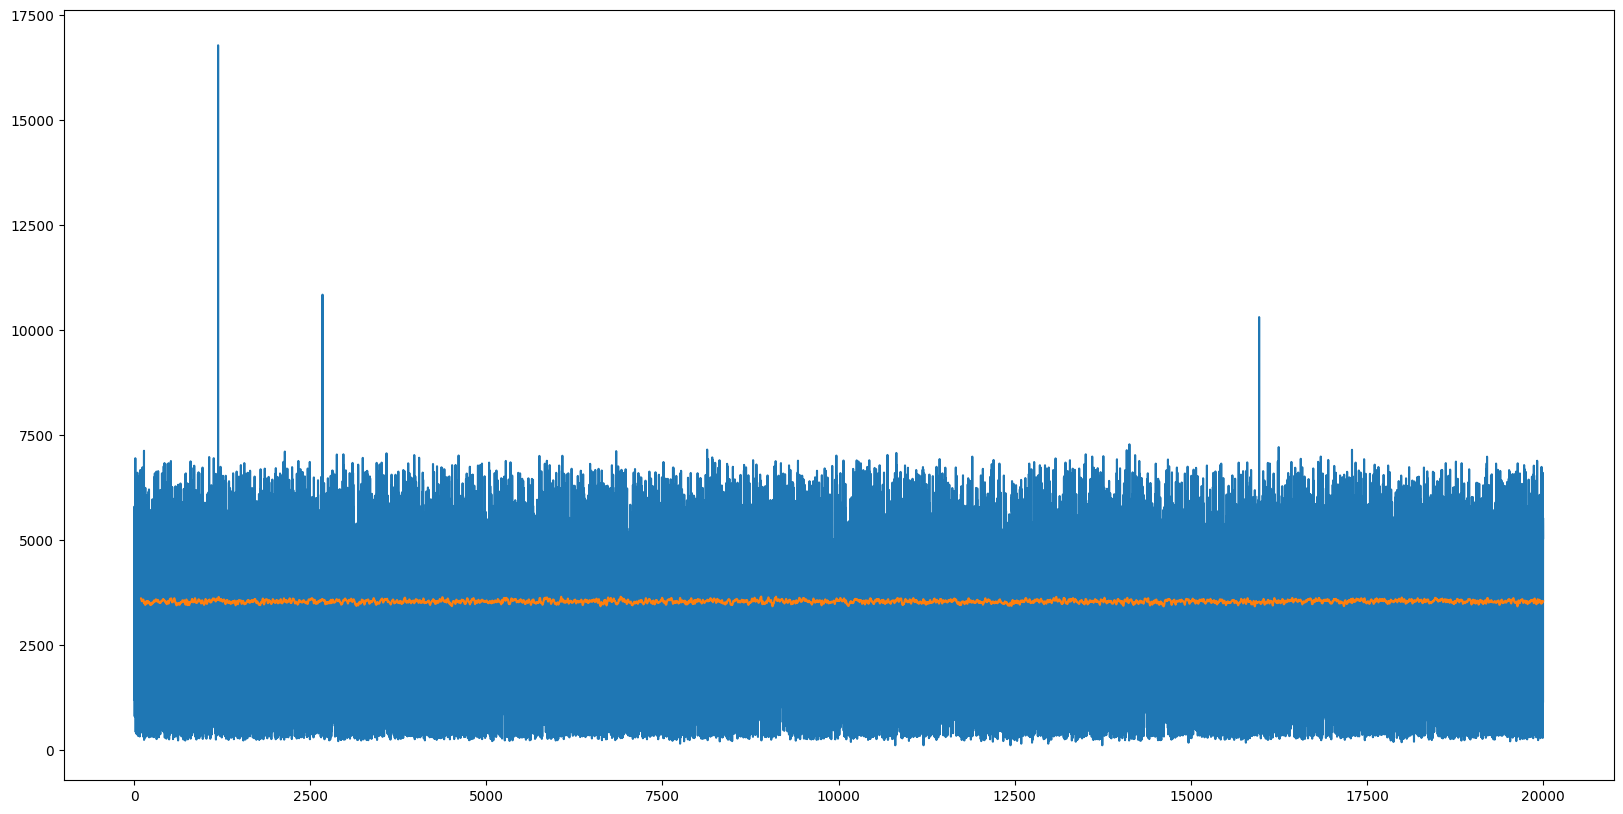

In [96]:

plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [72]:
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=50, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1))



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [74]:
gru_model.compile(optimizer='adam', loss='mean_squared_error')


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [76]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [79]:

X_train, Y_train = create_dataset(scaled_data, 100)
X_test, Y_test = create_dataset(scaled_data, 100)

gru_history = gru_model.fit(X_train, Y_train, epochs=2, batch_size=32, validation_data=(X_test, Y_test), verbose=1)


Epoch 1/2
622/622 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 2/2
622/622 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0142 - val_loss: 0.0141


In [80]:
gru_predictions = gru_model.predict(X_test)


622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [86]:
gru_rmse = np.sqrt(mean_squared_error(Y_test, gru_predictions))
print(f'GRU RMSE: {gru_rmse}')


GRU RMSE: 0.11884911946697299


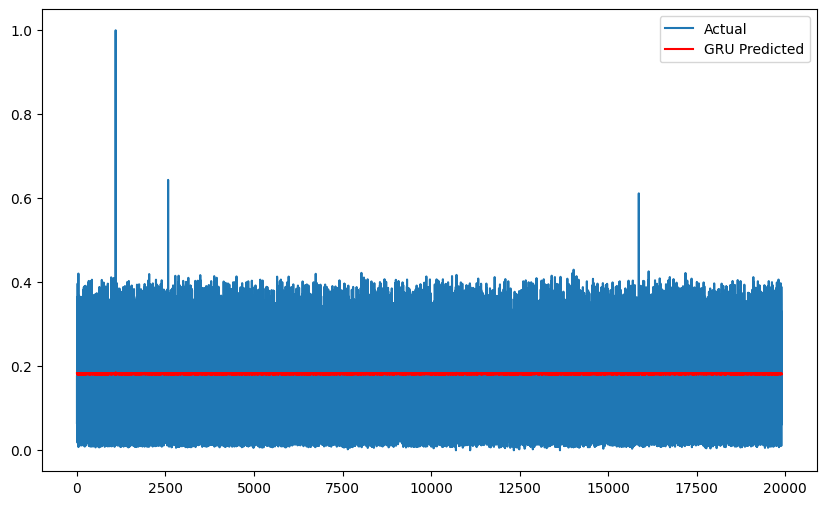

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual')
plt.plot(gru_predictions, label='GRU Predicted', color='red')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain How you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

1. i used forward technique (ffill) because its sequence data and cant delete nan values,so i fill it use forward tech
2. i used shift +1 and add Prev_traffic_volume column as requierd and print the df is showing the firs row is nan
3. i choose the LSTM & GRU to compare the results between them  
4. i tried to make it 50 epochs but its take loooong time, so i replace it to 2 
5. i choose rmse 

i face a lot of errors in defining the but i hope reach the target.

THANKS